In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets_df3_org')

In [5]:
df2 = df

In [6]:
original_df = df2.filter(df2.retweeted_status.isNull())

In [8]:
df_celeb = original_df.filter(original_df.organization == 'Celebrity')

In [9]:
df_text_raw = df_infl.select(["text"])

In [10]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [11]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [12]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [13]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [14]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [15]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [16]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [17]:
df_dups_30 = df_dups_text

In [ ]:
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.0,37740,37759,[Work Related Inj...,[Work Related Inj...
0.0,17440,26385,[If you’re over 5...,[If you’re over 5...
0.0,23810,25483,[#VaccineCentury ...,[#VaccineCentury ...
0.19999999999999996,22419,23810,[#VaccineCentury ...,[#VaccineCentury ...
0.16666666666666663,27214,27239,[OUT NOW from @Af...,[ICYMI: Check out...
0.0,9132,9170,[‘They are spooke...,[‘They are spooke...
0.0,10976,10979,[Latest #COVID19 ...,[Latest #COVID19 ...
0.0,21267,29456,[This autumn/wint...,[💉 This autumn/w...
0.0,6573,6593,[Swissmedic has a...,[Swissmedic has a...
0.2857142857142857,8882,22011,[JOHNSON AND JOHN...,[BREAKING: An FDA...


In [19]:
records = df_hashed_text.count()  # 46114

In [25]:
records

46114

In [28]:
dups = df_dups_text.select('id_A').distinct().count()  # 8391

In [29]:
dups

8391

In [30]:
uniques = records - dups  # 37723

In [31]:
uniques

37723

In [32]:
dups = dups/records * 100 

In [33]:
uniques = uniques/records * 100

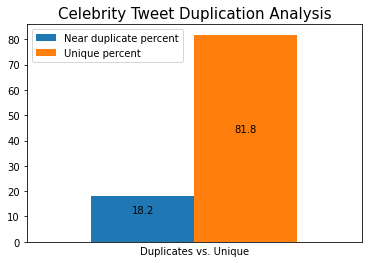

In [34]:
dups_df = pd.DataFrame.from_dict({'Near duplicate percent': [dups], 'Unique percent': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['Near duplicate percent', 'Unique percent'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Celebrity Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
       ax.set_xticks([])